In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
from matplotlib.colors import ListedColormap
#Iscrtavanje novo
def plot_results_2(x_train, y_train, knn):
  h = 0.005
  x_min, x_max = x_train[:, 0].min(), x_train[:, 0].max() + 0.01
  y_min, y_max = x_train[:, 1].min(), x_train[:, 1].max() + 0.01
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  x_vectors = np.stack((xx.ravel(), yy.ravel()), axis=1)

  z = knn.predict({'x': x_vectors, 'y': np.zeros(len(xx.ravel()))}).reshape(xx.shape)


  cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
  cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
  z = z.reshape(xx.shape)
  plt.pcolormesh(xx, yy, z, cmap=cmap_light)


  plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=50)


  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())


  plt.xlabel('Room Service')
  plt.ylabel('Food Court')


plt.show()

643 matches out of 865 examples
Test set accuracy: 0.7433526011560694


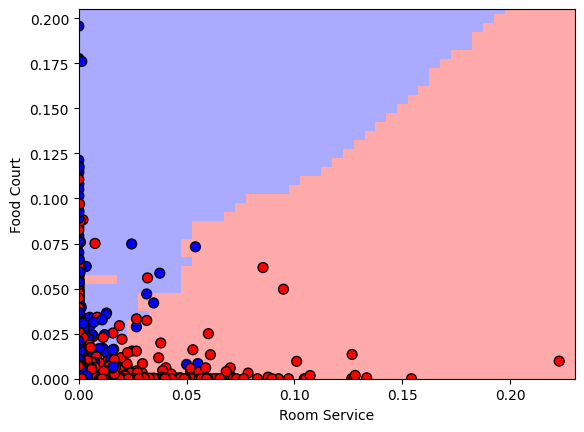

In [ ]:
#Ucitavanje podataka
filename = '/content/drive/MyDrive/Colab Notebooks/Domaci1/Zadatak2/spaceship-titanic.csv'
#ucitavanje tabele i izbacivanje redova gde FoodCourt ili RoomService ili Transported nemaju vrednost
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Domaci1/Zadatak2/spaceship-titanic.csv').dropna(subset=['FoodCourt', 'RoomService', 'Transported'])

#izbacivanje redova gde su i FoodCourt i RoomService jednaki 0
df = df.loc[~((df['FoodCourt'] == 0) & (df['RoomService'] == 0))]


food_court = df['FoodCourt'].to_numpy()
room_service = df['RoomService'].to_numpy()
transported = df['Transported'].to_numpy().astype(int)

#Normalizacija
food_court = normalize([food_court])[0]
room_service = normalize([room_service])[0]


length = len(food_court)

#20% of data is test data
food_court_test = food_court[:int(length/5)]
room_service_test = room_service[:int(length/5)]
transported_test = transported[:int(length/5)]

#the rest is train data
food_court_train = food_court[int(length/5):]
room_service_train = room_service[int(length/5):]
transported_train = transported[int(length/5):]

#vektori za testiranje
x_test = np.stack((room_service_test, food_court_test), axis=1)
y_test = transported_test

#vektori za trening
x_train = np.stack((room_service_train, food_court_train), axis=1)
y_train = transported_train

#Iscrtavanje vektora za trening
# x = x_train[:, 0]
# y = x_train[:, 1]

# colors = y_train

# plt.scatter(x,y, c=colors)
# plt.show()

class KNN:

  def __init__(self, nb_features, nb_classes, data, k, weighted = False):
    self.nb_features = nb_features
    self.nb_classes = nb_classes
    self.k = k
    self.weighted = weighted
    self.X = tf.convert_to_tensor(data['x'], dtype=tf.float32)
    self.Y = tf.convert_to_tensor(data['y'], dtype=tf.int32)

  def predict(self, query_data, print_accuracy=False):

    #ne pokrecemo za sada za sve iz test vektora
    # nb_queries = 100
    nb_queries = len(query_data['x'])

    predict = []

    matches = 0

    for i in range(nb_queries):
      #racunamo distance trening vektora sa trenutnim test vektorom
      dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, query_data['x'][i])), axis=1))
      #f-ja tf.nn.top_k nam vraca indekse k najvecih distanci, ali zbog -dist nam vraca k najmanjih distanci
      _, idxs = tf.nn.top_k(-dists, self.k)

      classes = tf.gather(self.Y, idxs)
      dists = tf.gather(dists, idxs)

      if(self.weighted):
        w = 1 / dists
      else:
        w = tf.fill([self.k], 1/self.k)

      w_col = tf.reshape(w, (self.k, 1))
      classes_one_hot = tf.one_hot(classes, self.nb_classes)
      scores = tf.reduce_sum(w_col * classes_one_hot, axis=0)

      #klasa sa najvise glasova
      hyp = tf.argmax(scores)

      predict.append(hyp)

      if(query_data['y'] is not None):
        actual = query_data['y'][i]
        match = (hyp == actual)
        if(match):
          matches += 1
    if(print_accuracy):
      accuracy = matches / nb_queries
      print(f'{matches} matches out of {nb_queries} examples')
      print(f'Test set accuracy: {accuracy}')
    return(np.array(predict))


#Pokretanje testova
nb_features = 2
nb_classes = 2
k = 15
train_data = {'x': x_train, 'y': y_train}
test_data = {'x': x_test, 'y': y_test}

knn = KNN(nb_features, nb_classes, train_data, k, False)
knn.predict(test_data, print_accuracy=True)

plot_results_2(x_train, y_train, knn)
















